In [2]:
import matplotlib.pyplot as plt
import mpl_toolkits.mplot3d
import numpy as np
import scipy.sparse as scps
import scipy.sparse.linalg as ssl
import math

In [3]:
def maillage(n):
#
# Une discretisation possible d'une EDP elliptique sur le domaine ]0,1[ x ]0,1[
# Le carre [0,1]x[0,1] est maille uniquement avec des triangles; 
# Les conditions limites sont de type Dirichlet uniquement   => neumann  =[];
#
# Entrees :
# n : nombre de points par cote du carre => Npts points de discretisation au
# total
#
# Sorties :
# coordinates : matrice a deux colonnes. Chaque ligne contient les 
# coordonnes 2D d'un des points de la discretisation. Ces sommets seront 
# identifies a l'indice de la ligne correspondante dans la matrice
# coordinates.
# elements3 : matrice a trois colonnes. Chaque ligne contient les indices 
# des sommets d'un element triangle, dans le sens antihoraire. 
# dirichlet : vecteur colonne des indices des sommets de la frontiere de
# Dirichlet.
# neumann : matrice a deux colonnes. Chaque ligne contient les indices 
# des deux sommets d'une arete de la frontiere de Neumann.
# (neumann est vide sur cet exemple)
#
##################################################################################
    h=1/(n-1)
    npoin       = n*n ; 
    nelem       = 2*(n-1)*(n-1) ;
    coordinates = np.zeros((npoin,2)); 
    elements3   = (np.zeros((nelem,3))).astype(int) ;
    neumann     = [];
    dirichlet=(np.zeros((4*n-4,1))).astype(int)
    # Coordonnees et connectivites :
    e = -1 ; 
    p = -1 ;
    x=np.zeros((n+1,1))
    x[n,0]=1.
    for l in range (n+1):
        x[l,0]=l*h
    for j in range (n):
            for i in range(n):
                p = p + 1  
                coordinates[p,0] = x[i,0]  
                coordinates[p,1] = x[j,0] 
                if ((i != n-1) & (j != n-1)):
                    p1 = p
                    p2 = p1 + 1 
                    p3 = p1 + n 
                    p4 = p2 + n 
                    e = e + 1 
                    elements3[e,0] = p1 
                    elements3[e,1] = p2 
                    elements3[e,2] = p3 
                    e = e + 1
                    elements3[e,0] = p4 
                    elements3[e,1] = p3 
                    elements3[e,2] = p2 
    #Liste des sommets de la frontiere de Dirichlet:
    p=-1
    for j in range(n):
        p=p+1
        dirichlet[p,0] = j  
    for j in range(n*2-1,n*(n-1),n):
        p=p+1
        dirichlet[p,0] = j 
    for j in range(n*n-1,n*n-n-1,-1):
        p=p+1
        dirichlet[p,0] = j 
    for j in range(n*n-2*n,n-1,-n):
        p=p+1
        dirichlet[p,0] = j 

    return coordinates, elements3, dirichlet, neumann

In [4]:
def show(coordinates,u):
#
# Fonction d'affichage de la solution u sur le maillage defini par
# elements3, coordinates.
#
# Entrees:
# elements3 : matrice a trois colonnes contenant les elements triangles
# de la discretisation, identifies par les indices de leurs trois
# sommets.
# coordinates : matrice a deux colonnes contenant les coordonnes 2D des
# points de la discretisation.
# u : vecteur colonne de longueur egale au nombre de lignes de
# coordinates contenant les valeurs de la solution a afficher aux
# points de la discretisation.
#
# Sorties : Aucune, mais la fonction doit s'afficher dans une figure.
##########################################################################
    ax= plt.figure().add_subplot(projection='3d')
    ax.plot_trisurf(coordinates[:,0],coordinates[:,1],u,linewidth=0.2,antialiased=True)
    plt.show()

**Partie I : maillage triangulaire et conditions de Dirichlet**

In [5]:
def mat_raideur_elementaire(indice, elements3, coordinates, f):
    #récupère les points du triangle
    triangle = elements3[indice]
    #récupère les coordonées des points
    [x1,y1] = coordinates[triangle[0]]
    [x2,y2] = coordinates[triangle[1]]
    [x3,y3] = coordinates[triangle[2]]
    #calcul de alpha
    alpha = (x2 - x1)*(y3 - y1) - (y2 - y1)*(x3 -x1)
    #calcul des gradients
    gradients = np.zeros((3,2))
    gradients[0] = np.multiply([y2 - y3, x3 - x2],(1/alpha))
    gradients[1] = np.multiply([y3 - y1, x1 - x3],(1/alpha))
    gradients[2] = np.multiply([y1 - y2, x2 - x1],(1/alpha))
    #calcul de l'aire du triangle
    T = alpha / 2
    #calcul de M
    M = T * np.dot(gradients,np.transpose(gradients))
    #calcul du second terme
    #calcul du barycentre
    xg = (x1+x2+x3) / 3
    yg = (y1+y2+y3) / 3
    z = (alpha / 6)*f(xg, yg)
    return [M, z]


def assemblage_A(elements3, coordinates, ud, dirichlet, f):
    #récupère le nombre de triangles
    Nt = len(elements3)
    #récupère le nombre de points
    Np = len(coordinates)
    #création de la matrice A et b
    A = np.zeros((Np, Np))
    b = np.zeros(Np)
    uh = np.zeros(Np)
    for l in dirichlet:
        uh[l[0]] = ud(coordinates[l[0]][0], coordinates[l[0]][1])
    #On boucle sur les triangles
    for i in range (0,Nt):
        [Mt, z] = mat_raideur_elementaire(i, elements3, coordinates, f)
        triangle = elements3[i]
        for ii in range(3):
            for jj in range (3):
                A[triangle[ii]][triangle[jj]] += Mt[ii][jj]
            b[triangle[ii]] += z
    b = b - np.dot(A,uh)
    return A,b


#sous matrice de A en enlevant les valeurs à la frontière
def sous_matrice(A, b, dirichlet, n):
    indice = np.setdiff1d(np.array(range(n*n)), dirichlet)
    Abis = A[indice]
    Abis = np.transpose(Abis)
    Abis = Abis[indice]
    Abis = np.transpose(Abis)
    bbis = b[indice]
    return Abis,bbis,indice
                          
    

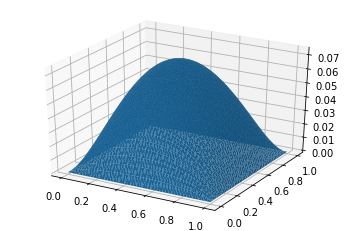

In [12]:
n = 50
coordinates, elements3, dirichlet, neumann = maillage(n)
def ud(x,y):
    return 0

def f(x,y):
    return 1
[A, b] = assemblage_A(elements3, coordinates, ud, dirichlet, f)
Abis,bbis,indice = sous_matrice(A,b,dirichlet,n)
u = np.zeros(n*n)
for i in dirichlet:
    u[i[0]] = ud(coordinates[i[0]][0],coordinates[i[0]][1])
u[indice] = np.linalg.solve(Abis, bbis)
show(coordinates,u)

In [12]:
print(np.linalg.norm(u-(np.sin(np.pi*coordinates[:,0])*np.sin(np.pi*coordinates[:,1]))/(2*np.pi**2)))

0.0007163344167936711


In [123]:
i = np.array([1, 3])
A = np.array([[1,2,3,4], [5,6,7,8], [5,6,7,8], [5,6,7,8]])

print(dirichlet.flatten())

[   0    1    2    3    4    5    6    7    8    9   10   11   12   13
   14   15   16   17   18   19   20   21   22   23   24   25   26   27
   28   29   30   31   32   33   34   35   36   37   38   39   40   41
   42   43   44   45   46   47   48   49   99  149  199  249  299  349
  399  449  499  549  599  649  699  749  799  849  899  949  999 1049
 1099 1149 1199 1249 1299 1349 1399 1449 1499 1549 1599 1649 1699 1749
 1799 1849 1899 1949 1999 2049 2099 2149 2199 2249 2299 2349 2399 2449
 2499 2498 2497 2496 2495 2494 2493 2492 2491 2490 2489 2488 2487 2486
 2485 2484 2483 2482 2481 2480 2479 2478 2477 2476 2475 2474 2473 2472
 2471 2470 2469 2468 2467 2466 2465 2464 2463 2462 2461 2460 2459 2458
 2457 2456 2455 2454 2453 2452 2451 2450 2400 2350 2300 2250 2200 2150
 2100 2050 2000 1950 1900 1850 1800 1750 1700 1650 1600 1550 1500 1450
 1400 1350 1300 1250 1200 1150 1100 1050 1000  950  900  850  800  750
  700  650  600  550  500  450  400  350  300  250  200  150  100   50]


**Partie II : maillage mixte et ajoût des conditions de Neumann**

In [ ]:
def mat_raideur_elementaire_quadrangle(indice, elements4, coordinates, f):
    #récupère les points du triangle
    quadrangle = elements4[indice]
    #récupère les coordonées des points
    [x1,y1] = coordinates[quadrangle[0]]
    [x2,y2] = coordinates[quadrangle[1]]
    [x3,y3] = coordinates[quadrangle[2]]
    [x4,y4] = coordinates[quadrangle[3]]
    #calcul de alpha
    alpha = (x2 - x1)*(y3 - y1) - (y2 - y1)*(x3 -x1)
    #calcul des gradients
    gradients = np.zeros((3,2))
    gradients[0] = np.multiply([y2 - y3, x3 - x2],(1/alpha))
    gradients[1] = np.multiply([y3 - y1, x1 - x3],(1/alpha))
    gradients[2] = np.multiply([y1 - y2, x2 - x1],(1/alpha))
    #calcul de l'aire du triangle
    T = alpha / 2
    #calcul de M
    M = T * np.dot(gradients,np.transpose(gradients))
    #calcul du second terme
    #calcul du barycentre
    xg = (x1+x2+x3) / 3
    yg = (y1+y2+y3) / 3
    z = (alpha / 6)*f(xg, yg)
    return [M, z]

In [13]:
############################# Maillage mixte ################
e3=np.array([[1,2,12],[2,3,12],[3,4,14],[4,5,14],[2,15,3],[3,15,4]]).astype(int)
e4=np.array([[0,1,12,11],[11,12,13,10],[12,3,14,13],[10,13,8,9],[13,14,7,8],[14,5,6,7]]).astype(int)
dds=np.array([2,15,4,6,7,8,9,10,11,0]).astype(int)
nns=np.array([[4,5],[5,6],[0,1],[1,2]]).astype(int)
ccs=np.array([[0.,0.],[0.33333333333333,0],[0.53333333333333,0.],
                      [0.66666666666667,0.33333333333333],[1.,0.47],[1,0.66666666666667],
                     [1.,1.],[0.66666666666667,1.],[0.33333333333333,1.], [0.,1.],
                     [0.,0.66666666666667],[0.,0.33333333333333],[0.33333333333333,0.33333333333333],
                     [0.33333333333333,0.66666666666667],[0.66666666666667,0.66666666666667],[1.,0.]])

In [35]:
print(elements3)

[[   0    1   50]
 [  51   50    1]
 [   1    2   51]
 ...
 [2498 2497 2448]
 [2448 2449 2498]
 [2499 2498 2449]]


**Compléments  :  un nouveau terme dans l'EDP**